This notebook shows how to **construct** **vector fields** from **components** and **visualize** them.

# IMPORTS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import plotly.graph_objects as go


from spomso.cores.helper_functions import generate_grid, smarter_reshape, vector_smarter_reshape
from spomso.cores.geom_vector import CartesianVectorField, CylindricalVectorField, SphericalVectorField

# PARAMETERS

In [2]:
# size of the volume
co_size = 10, 10, 10
# resolution of the volume
co_resolution = 100, 100, 50

# show 2D cross-section along the z-axis
show_midplane = True
# index of the cross-section along the z-axis
depth_index = co_resolution[2]//2
# 1/decimate of total vectors are shown in the cross-section
decimate = 4

# how the vector field is defined: XYZ, CYLINDRICAL, SPHERICAL
define_type = "CYLINDRICAL"

# show a 3D plot
show_3d = True
show_field = True
show_field_3d = True

There are 3 sub-examples in this notebook showing how to construct a vector field from components. The vector fields can be constructed in the:

* Cartesian (XYZ)
* Cylindrical (CYLINDRICAL)
* Spherical (SPHERICAL)

coordinate system.

# COORDINATE SYSTEM

Point cloud of coordinates is created with the **generate_grid** function, which takes the size of the coordinate system and the number of points in each direction (**co_resolution**).

In [3]:
coor, co_res_new = generate_grid(co_size, co_resolution)

If there is an even number of points along any direction the function will automatically convert it to an odd number, therefore the origin is always included in the point cloud. The point cloud is a **numpy.ndarray** with a shape of **(D, N)**, where **D** is the number of dimensions and **N** is the number of data points.

# CREATE VECTOR FIELDS

Create **components** of the vector field in the **spherical** coordinate system:

In [4]:
r_ = np.ones(coor.shape[1])
phi_ = np.pi*coor[0]/(co_size[0]/2)
theta_ = np.pi*coor[2]/co_size[2] + np.pi/2

Define the vector field in the **cartesian** coordinate system:

In [5]:
if define_type == "XYZ":
    u = r_ * np.cos(phi_) * np.sin(theta_)
    v = r_ * np.sin(phi_) * np.sin(theta_)
    w = r_ * np.cos(theta_)

    coordinates = np.asarray((u, v, w))
    final = CartesianVectorField()

Define the vector field in the **cylindrical** coordinate system:

In [6]:
if define_type == "CYLINDRICAL":
    z_ = r_*np.cos(theta_)
    rc = r_*np.sin(theta_)

    coordinates = np.asarray((rc, phi_, z_))
    final = CylindricalVectorField()


Define the vector field in the **spherical** coordinate system:

In [7]:
if define_type == "SPHERICAL":
    coordinates = np.asarray((r_, phi_, theta_))
    final = SphericalVectorField()

**Rotate** vectors for some **azimuthal** angle:

In [8]:
final.rotate_phi(np.pi/2)

<function spomso.cores.modifications.ModifyVectorObject.rotate_phi.<locals>.new_vf(p, *params)>

**Rotate** vectors for some **polar** angle:

In [9]:
final.rotate_theta(-np.pi/4)

<function spomso.cores.modifications.ModifyVectorObject.rotate_theta.<locals>.new_vf(p, *params)>

**Rescale** vectors by a factor:

In [10]:
scale_ = np.abs(coor[2]/co_size[2]) + 0.1
final.rescale(scale_)

<function spomso.cores.modifications.ModifyVectorObject.rescale.<locals>.new_vf(p, *params)>

**Add** or **subtract** a vector field and **normalize**:

In [11]:
second = SphericalVectorField()
second_coordinates = np.asarray((r_, phi_*0, -theta_))
second_vector_field = second.create(second_coordinates)

**Add**:

In [12]:
final.add(second_vector_field)

<function spomso.cores.modifications.ModifyVectorObject.add.<locals>.new_vf(p, *params)>

**Subtract**:

In [ ]:
final.subtract(second_vector_field)

**Normalize**:

In [13]:
final.normalize()

<function spomso.cores.modifications.ModifyVectorObject.normalize.<locals>.new_vf(p, *params)>

## EVALUATE

Evaluate the **vector field** functions to create a map of the **vector field**. This is done by calling the **create** method and passing in the point cloud of coordinates:

In [14]:
final_field = final.create(coordinates)

# EXTRACT

Extract the **x**, **y**, and **z** components of the **vector field**:

In [15]:
x = final.x(coordinates)
y = final.y(coordinates)
z = final.z(coordinates)

Extract the **phi** (azimuthal) and **theta** (polar) angles, and the vector **lengths**:

In [16]:
phi = final.phi(coordinates)
theta = final.theta(coordinates)
length = final.length(coordinates)

Convert the field maps into grids:

In [17]:
field = vector_smarter_reshape(final_field, co_resolution)
x = smarter_reshape(x, co_resolution)
y = smarter_reshape(y, co_resolution)
z = smarter_reshape(z, co_resolution)
phi = smarter_reshape(phi, co_resolution)
theta = smarter_reshape(theta, co_resolution)
length = smarter_reshape(length, co_resolution)

# PLOT

## XY plane


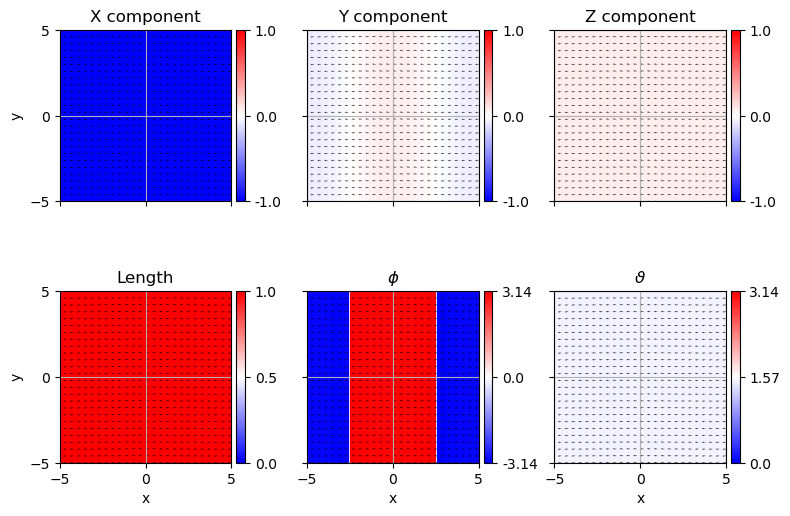

In [18]:
if show_midplane:
    fig, axs = plt.subplots(2, 3, figsize=(8.25, 2*8.25/3), sharex="col", sharey="row")

    patterns = ((x, y, z), (length, phi, theta))
    titles = (("X component", "Y component", "Z component"), ("Length", r"$\phi$", r"$\vartheta$"))
    mins = ((-1, -1, -1), (0, -np.pi, 0))
    maxs = ((1, 1, 1), (1, np.pi, np.pi))

    for i in range(2):
        for j in range(3):
            ax = axs[i, j]

            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.05)

            f = ax.imshow(patterns[i][j][:, :, depth_index].T,
                          cmap="bwr",
                          extent=(-co_size[0]/2, co_size[0]/2,
                                  -co_size[1]/2, co_size[1]/2),
                          origin="lower",
                          vmin=mins[i][j],
                          vmax=maxs[i][j]
                      )

            cbar = fig.colorbar(f, cax=cax)
            cbar.set_ticks(np.linspace(mins[i][j], maxs[i][j], 3))
            cbar.set_ticklabels(np.round(np.linspace(mins[i][j], maxs[i][j], 3), 2))

            ax.set_xticks(np.linspace(-co_size[0]/2, co_size[0]/2, 3))
            ax.set_yticks(np.linspace(-co_size[1]/2, co_size[1]/2, 3))
            ax.grid()

            ax.quiver(smarter_reshape(coor[0], co_resolution)[::decimate, ::decimate, depth_index],
                      smarter_reshape(coor[1], co_resolution)[::decimate, ::decimate, depth_index],
                      field[0, ::decimate, ::decimate, depth_index],
                      field[1, ::decimate, ::decimate, depth_index])

            if i == 1:
                ax.set_xlabel("x")
            if j == 0:
                ax.set_ylabel("y")

            ax.set_title(titles[i][j])

    fig.tight_layout()
    fig.subplots_adjust(left=0.112,
                        bottom=0.05,
                        right=0.936,
                        top=1,
                        wspace=0.336,
                        hspace=0.0)
    plt.show()

## XZ plane

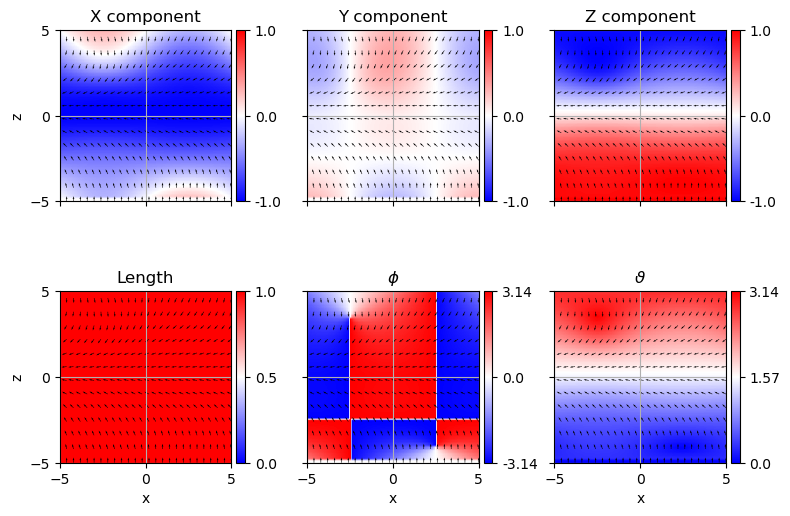

In [19]:
if show_midplane:
    fig, axs = plt.subplots(2, 3, figsize=(8.25, 2*8.25/3), sharex="col", sharey="row")

    patterns = ((x, y, z), (length, phi, theta))
    titles = (("X component", "Y component", "Z component"), ("Length", r"$\phi$", r"$\vartheta$"))
    mins = ((-1, -1, -1), (0, -np.pi, 0))
    maxs = ((1, 1, 1), (1, np.pi, np.pi))

    for i in range(2):
        for j in range(3):
            ax = axs[i, j]

            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            depth_index_xz = patterns[i][j].shape[1]//2
            f = ax.imshow(patterns[i][j][:, depth_index_xz, :].T,
                      cmap="bwr",
                      extent=(-co_size[0]/2, co_size[0]/2,
                              -co_size[2]/2, co_size[2]/2),
                      origin="lower",
                          vmin=mins[i][j],
                          vmax=maxs[i][j]
                      )

            cbar = fig.colorbar(f, cax=cax)
            cbar.set_ticks(np.linspace(mins[i][j], maxs[i][j], 3))
            cbar.set_ticklabels(np.round(np.linspace(mins[i][j], maxs[i][j], 3), 2))

            ax.set_xticks(np.linspace(-co_size[0]/2, co_size[0]/2, 3))
            ax.set_yticks(np.linspace(-co_size[2]/2, co_size[2]/2, 3))
            ax.grid()

            ax.quiver(smarter_reshape(coor[0], co_resolution)[::decimate, depth_index, ::decimate],
                      smarter_reshape(coor[2], co_resolution)[::decimate, depth_index, ::decimate],
                      field[0, ::decimate, depth_index, ::decimate],
                      field[2, ::decimate, depth_index, ::decimate])

            if i == 1:
                ax.set_xlabel("x")
            if j == 0:
                ax.set_ylabel("z")

            ax.set_title(titles[i][j])

    fig.tight_layout()
    fig.subplots_adjust(left=0.112,
                        bottom=0.05,
                        right=0.936,
                        top=1,
                        wspace=0.336,
                        hspace=0.0)
    plt.show()

## 3D

In [20]:
if show_3d:
    decimate3d = 2*decimate
    xx = smarter_reshape(coor[0], co_resolution)[::decimate3d, ::decimate3d, :].flatten()
    yy = smarter_reshape(coor[1], co_resolution)[::decimate3d, ::decimate3d, :].flatten()
    zz = smarter_reshape(coor[2], co_resolution)[::decimate3d, ::decimate3d, :].flatten()
    vx = field[0, ::decimate3d, ::decimate3d, :].flatten()
    vy = field[1, ::decimate3d, ::decimate3d, :].flatten()
    vz = field[2, ::decimate3d, ::decimate3d, :].flatten()
    phi_ = phi[::decimate3d, ::decimate3d, :].flatten()

    fig = go.Figure()

    fig = go.Figure(
        data=go.Cone(
            x=xx,
            y=yy,
            z=zz,
            u=vx,
            v=vy,
            w=vz,
            colorscale='Blues_r',
            sizemode="absolute",
            sizeref=3
        )
    )

    fig.update_layout(
        scene=dict(
            aspectmode="manual",
            aspectratio=dict(x=1, y=co_size[1]/co_size[0], z=co_size[2]/co_size[0])
        )
    )

    fig.show()